# Installation

In [17]:
!pip install imutils
!pip install scikit-learn
!pip install keras
!pip install opencv-python-headless==4.1.2.30
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 13.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.4.60
    Uninstalling opencv-python-headless-4.5.4.60:
      Successfully uninstalled opencv-python-headless-4.5.4.60
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


# Imports

In [16]:
import cv2
import numpy as np
import pandas as pd
import imutils
from matplotlib import pyplot as plt

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Model
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Dense, GlobalAvgPool2D

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


# Build Dataset for Training

In [ ]:
def buildDataset():
    """Building Dataset by combining both MNIST and A-Z Handwritten Dataset"""
    # Variable to store data
    final_data, final_label = [], []
    alpha_data, alpha_label = [], []
    mnist_data, mnist_label = [], []
    
    # A-Z Handwritten Dataset from Kaggle
    alphaData_df = pd.read_csv("/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv")
    for row in range(alphaData_df.shape[0]):
        image = np.array([int(pixel) for pixel in alphaData_df.iloc[row,1:]], dtype='uint8')
        label = alphaData_df.iloc[row,0]
        alpha_data.append(image)
        alpha_label.append(label)
    alpha_data = np.array(alpha_data, dtype='float32')
    alpha_label = np.array(alpha_label, dtype='uint8')
        
    # Mnist data
    (train_data, train_label), (test_data, test_label) = mnist.load_data()
    mnist_data = np.vstack([train_data, test_data])
    mnist_label = np.hstack([train_label, test_label])
    # Reshaping the data, in order to merge with A-Z handwritten dataset
    mnist_data = mnist_data.reshape(mnist_data.shape[0], 784)
    
    # Adding 10 to alphabet label data, in order to avoid label data confusion between numeric and alphabet data
    alpha_label += 10

    final_data = np.vstack([alpha_data, mnist_data])
    final_label = np.hstack([alpha_label, mnist_label])
    
    return final_data, final_label

In [ ]:
def SplitAndScaledDataset(data, label):
    """Split Dataset using train test split and then applying min max scaling"""
    x_train, x_test, y_train, y_test = train_test_split(data, label,test_size=0.20,stratify=label,random_state=42)

    # MinMax Scaling, can detect outliers
    standard_scaler = MinMaxScaler()
    train_scaled = standard_scaler.fit_transform(x_train)
    test_scaled = standard_scaler.transform(x_test)
    
    # Changing format of data to be model compatible
    train_scaled = np.array(train_scaled, dtype='float32')
    test_scaled = np.array(test_scaled, dtype='float32')
    train_scaled = train_scaled.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
    test_scaled = test_scaled.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

    # convert the labels to categorical (One Hot Encoding)
    # y_train = np_utils.to_categorical(y_train)
    # y_test = np_utils.to_categorical(y_test)
    
    return train_scaled, test_scaled, y_train, y_test

# CNN Model 

In [10]:
def CreatConvModel():
    # Model Architecture
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal', input_shape=(28, 28, 1)))
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal'))
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal'))
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal'))
    model.add(GlobalAvgPool2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(36, activation='sigmoid'))

    model.summary()

    # Compile
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

SeqModel = CreatConvModel()

2023-02-18 10:57:30.657447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-18 10:57:30.657501: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-18 10:57:30.657541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (21271c1176c0): /proc/driver/nvidia/version does not exist
2023-02-18 10:57:30.657938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 32)         128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                        

In [12]:
# Callbacks
cbs = [EarlyStopping(patience=3, restore_best_weights=True), ModelCheckpoint("TextDetectionModel-v1.h5", save_best_only=True)]

# Training
SeqModel.fit(
    train_scaled,
    y_train,
    epochs=14,
    callbacks=cbs
)

# SeqModel.save("TextDetectionModel-v1.h5")

Epoch 1/14
11062/11062 [==============================] - 172s 15ms/step - loss: 0.2542 - accuracy: 0.9271
Epoch 2/14
11062/11062 [==============================] - 170s 15ms/step - loss: 0.1422 - accuracy: 0.9592
Epoch 3/14
11062/11062 [==============================] - 170s 15ms/step - loss: 0.1133 - accuracy: 0.9672
Epoch 4/14
11062/11062 [==============================] - 169s 15ms/step - loss: 0.0974 - accuracy: 0.9715
Epoch 5/14
11062/11062 [==============================] - 170s 15ms/step - loss: 0.0887 - accuracy: 0.9742
Epoch 6/14
11062/11062 [==============================] - 169s 15ms/step - loss: 0.0820 - accuracy: 0.9761
Epoch 7/14
11062/11062 [==============================] - 169s 15ms/step - loss: 0.0773 - accuracy: 0.9769
Epoch 8/14
11062/11062 [==============================] - 169s 15ms/step - loss: 0.0733 - accuracy: 0.9786
Epoch 9/14
11062/11062 [==============================] - 169s 15ms/step - loss: 0.0704 - accuracy: 0.9791
Epoch 10/14
11062/11062 [============

In [32]:
model.evaluate(test_scaled, y_test)

# Accuracy: 98%

2766/2766 [==============================] - 17s 6ms/step - loss: 0.0672 - accuracy: 0.9817


[0.06717652082443237, 0.9816815257072449]

# Functions to extract Text

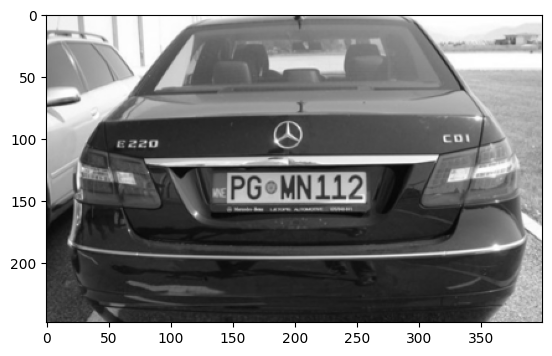

In [17]:
def ExtractNumberPlateFromImage(filepath_img='/carimage/car-1.png'):    
    # Convert color image to gray
    image = cv2.imread(filepath_img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

    # Detect Edge from gray image
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)  # daimeter, sigma color, sigma space
    edge = cv2.Canny(bfilter, 30, 200)
    #plt.imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))
    
    # finding rectangle shape from edges
    keypoints = cv2.findContours(edge.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    
    # Finding contour point in imagese which align closely with character
    location=None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx)==4:
            location=approx
            break
    
    # Mask image and extract copy using bitwise
    mask = np.zeros(gray.shape, np.uint8)
    new_img = cv2.drawContours(mask, [location], 0, 255, -1)
    new_img = cv2.bitwise_and(img, img, mask=mask)
    #plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
    
    # Cropped only mask part from image
    (x,y) = np.where(mask==255)
    (x1,y1) = (np.min(x), np.min(y))
    (x2,y2) = (np.max(x), np.max(y))
    cropped_image = gray[x1:x2+1, y1:y2+1]
    
    # Saved Extrated Number Plate Image
    cv2.imwrite("NumberPlate.png", cropped_image)
    
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.show()
    
    return cropped_image

In [ ]:
def predictTextCharacterwise(cropped_image, model):
    # Number Plate Image, extracted after preprocessing
    r = cropped_image.copy()

    # To find character in text, do find contour on thershold image
    ret, thresh = cv2.threshold(r, 127,255,cv2.THRESH_BINARY)
    contours=cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # Declare Variable to be used
    THRESH_CONTOUR=10
    filenam,ext='savedImage','.jpg'
    numberPlatePred = ""

    # Loop on contour and filter them
    for cnt in contours:
        approx = cv2.approxPolyDP(contour, 5, True)
        # To find rectangle
        if len(approx)==4:
            x,y,w,h=cv2.boundingRect(cnt)
            
            # Each contour represents a single character in Number plate
            # Filter contour with large width and height
            if THRESH_CONTOUR<w<h:
                #mask the image
                mask = np.zeros(r.shape, np.uint8)
                mask_img = cv2.drawContours(mask, [cnt], 0, 255, -1)
                mask_img = cv2.bitwise_and(r, r, mask=mask)

                # Cropping : Extract pixel where contour points are located from masked image
                (x0,y0) = np.where(mask==255)
                (x1,y1) = (np.min(x0), np.min(y0))
                (x2,y2) = (np.max(x0), np.max(y0))
                croped_image = mask_img[x1:x2+1, y1:y2+1]

                filenam += '1'
                class_mapping = {}
                alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
                for i in range(len(alphabets)):
                    class_mapping[i] = alphabets[i]
                class_mapping
                pred += class_mapping[int(np.argmax(model.predict(resized_image.reshape(-1,28,28,1)))) - 10]

                resized_image = cv2.resize(croped_image, (28,28), interpolation=cv2.INTER_AREA)

                cv2.imwrite(filenam+ext, resized_image)
                cv2.rectangle(r, (x,y), (x+w,y+h), (0,128,0),1)
    plt.imshow(r) # Shows number plate image with boundings on each character
    plt.show()
    return numberPlatePred

# Alternate Solution using EasyOCR
def ExtractTextUsingEasyOCR(image):
    reader = easyocr.Reader(['en'])
    result = reader.readtext(image)
    return result